<a href="https://colab.research.google.com/github/fazaghifari/BayesianOptTools/blob/newver/Multi_objective_Bayesian_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MOBO, Constraint Handling, and Custom Function

In this notebook, a tutorial about Multi-objective Bayesian Optimization (MOBO) in KADAL will be provided. In the previous notebook, only unconstrained problem in SOBO with built-in function is provided. Meanwhile, in this notebook we will try using a custom function with constraint(s) provided.

First, let's install the packages

In [0]:
!pip install git+https://github.com/flowdiagnosticsitb/KADAL.git
!pip install cma

  Cloning https://github.com/flowdiagnosticsitb/KADAL.git to /tmp/pip-req-build-6e0dt_xw
  Running command git clone -q https://github.com/flowdiagnosticsitb/KADAL.git /tmp/pip-req-build-6e0dt_xw
     |████████████████████████████████| 204kB 2.7MB/s 
     |████████████████████████████████| 686kB 8.7MB/s 
     |████████████████████████████████| 419kB 14.0MB/s 
     |████████████████████████████████| 204kB 17.1MB/s 
  Created wheel for kadal: filename=kadal-1.0.2-cp36-none-any.whl size=77600 sha256=e662b8276350298e12d41e29619de40b22d720af7dfd5527c2b3d9ddf57591c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-j83a6492/wheels/3c/fd/38/70e82ea24ca6ec25615628dafcc6174b1ba9f859aa5e3f237b
  Created wheel for configobj: filename=configobj-5.0.6-cp36-none-any.whl size=34546 sha256=b7bb5658964e296c9509b50a4fd9f48b8b8ea3285835800d6d75dced4510f003
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built kadal configobj
ERROR: c

## Import KADAL

In [0]:
from kadal.surrogate_models.kriging_model import Kriging
from kadal.surrogate_models.supports.initinfo import initkriginfo
from kadal.misc.sampling.samplingplan import sampling
from matplotlib import pyplot as plt
from kadal.optim_tools.MOBO import MOBO
from copy import deepcopy
import numpy as np

## Define Custom Function
In this case, we will use [Binh and Korn](https://en.wikipedia.org/wiki/Test_functions_for_optimization#Test_functions_for_multi-objective_optimization) function for multi-objective problem with 2 constraints. Although both constraints can be easily evaluated, we will treat one of them as an expensive constraint.

In [0]:
def cust_func(x):
    x1 = x[:,0]
    x2 = x[:,1]
    f = np.zeros(np.shape(x))
    f[:,0] = 4*x1**2 + 4*x2**2
    f[:,1] = (x1-5)**2 + (x2-5)**2
    return f

In [0]:
def cheap_const(x):
    """This function should return either 1 or 0, 1 for feasible 0 for infeasible"""
    if np.ndim(x) == 1:
        x = np.array([x])
    x1 = x[:,0]
    x2 = x[:,1]
    g = (x1-5)**2 + x2**2 <= 25 
    return g

In [0]:
def exp_const_eval(x):
    """This function should return the evaluation value of the constraint"""
    if np.ndim(x) == 1:
        x = np.array([x])
    x1 = x[:,0]
    x2 = x[:,1]
    g = (x1-8)**2 + (x2 + 3)**2
    return g

## Create Kriging function

In [0]:
def construct_krig(X, y, g, lb, ub):
    # Define input for constraint Kriging
    KrigConstInfo = initkriginfo()
    KrigConstInfo['X'] = X
    KrigConstInfo['y'] = g.reshape(-1,1) # should be in shape (n,1)
    KrigConstInfo['problem'] = exp_const_eval
    KrigConstInfo["nrestart"] = 5
    KrigConstInfo["ub"] = ub
    KrigConstInfo["lb"] = lb
    KrigConstInfo["optimizer"] = "lbfgsb"
    KrigConstInfo['limittype'] = '>='  # value of the expensive constraints should be more than equal 7.7
    KrigConstInfo['limit'] = 7.7

    # Define input for first objective Kriging
    KrigInfo1 = initkriginfo()
    KrigInfo1["X"] = X
    KrigInfo1["y"] = y[:,0].reshape(-1,1)
    KrigInfo1["problem"] = cust_func
    KrigInfo1["nrestart"] = 5
    KrigInfo1["ub"] = ub
    KrigInfo1["lb"] = lb
    KrigInfo1["optimizer"] = "lbfgsb"

    # Define input for second objective Kriging
    KrigInfo2 = deepcopy(KrigInfo1)
    KrigInfo2['y'] = y[:,1].reshape(-1,1)

    # Run Kriging
    krigobj1 = Kriging(KrigInfo1, standardization=True, standtype='default', normy=False, trainvar=False)
    krigobj1.train(parallel=False)
    loocverr1, _ = krigobj1.loocvcalc()

    krigobj2 = Kriging(KrigInfo2, standardization=True, standtype='default', normy=False, trainvar=False)
    krigobj2.train(parallel=False)
    loocverr2, _ = krigobj2.loocvcalc()

    krigconst = Kriging(KrigConstInfo, standardization=True, standtype='default', normy=False, trainvar=False)
    krigconst.train(parallel=False)
    loocverrConst, _ = krigconst.loocvcalc()

    print('LOOCV 1: ', loocverr1)
    print('LOOCV 2: ', loocverr2)
    print('LOOCV Constraint: ', loocverrConst)

    # List of Kriging objects, objective and constraints should be separated
    kriglist = [krigobj1, krigobj2]
    expconstlist = [krigconst]

    return kriglist, expconstlist

## Create optimizer handler

In [0]:
def optimize(kriglist, expconstlist):
    moboInfo = dict()
    moboInfo['nup'] = 5
    moboInfo['acquifunc'] = "ehvi"
    moboInfo['acquifuncopt'] = "diff_evo"
    cheapconstlist = [cheap_const]
    mobo = MOBO(moboInfo, kriglist, autoupdate=True, multiupdate=5, expconst=expconstlist,
                chpconst = cheapconstlist)
    xupdate, yupdate, supdate, metricall = mobo.run(disp=True)
    return xupdate, yupdate, supdate, metricall

## Run

In [0]:
nsample = 20
nvar = 2
lb = np.array([0,0])
ub = np.array([5,3])
sampoption = "halton"
samplenorm, sample = sampling(sampoption, nvar, nsample, result="real", upbound=ub, lobound=lb)
X = sample

# Evaluate function
y = cust_func(X)
g = exp_const_eval(X)

# Create Kriging
kriglist, expconstlist = construct_krig(X, y, g, lb, ub)

Begin train hyperparam.
Training 5 hyperparameter(s)
Training hyperparameter candidate no.1
Training hyperparameter candidate no.2
Training hyperparameter candidate no.3
Training hyperparameter candidate no.4
Training hyperparameter candidate no.5
Single Objective, train hyperparam, end.
Best hyperparameter is [0.5075763  0.73086336]
With NegLnLikelihood of -3.2263762903472326
Begin train hyperparam.
Training 5 hyperparameter(s)
Training hyperparameter candidate no.1
Training hyperparameter candidate no.2
Training hyperparameter candidate no.3
Training hyperparameter candidate no.4
Training hyperparameter candidate no.5
Single Objective, train hyperparam, end.
Best hyperparameter is [0.53829235 0.74724422]
With NegLnLikelihood of -26.215005187885993
Begin train hyperparam.
Training 5 hyperparameter(s)
Training hyperparameter candidate no.1
Training hyperparameter candidate no.2
Training hyperparameter candidate no.3
Training hyperparameter candidate no.4
Training hyperparameter candida

In [0]:
# Optimize
xupdate, yupdate, supdate, metricall = optimize(kriglist, expconstlist)

The number of restart for acquisition function optimization is not specified, setting BayesInfo.nrestart to 1.
The file name for saving the results is not specified, set the name to temporarydata.mat
EHVI sampling is not specified, set sampling to default
Begin multi-objective Bayesian optimization process.
Update no.: 1, F-count: 20, Maximum no. updates: 6
update number 1
time:  11.505268812179565  s
update number 2
time:  12.68720269203186  s
update number 3
time:  12.53145718574524  s
update number 4
time:  15.598429441452026  s
update number 5
time:  12.555871486663818  s
Update no.: 2, F-count: 25, Maximum no. updates: 6
update number 1
time:  19.41767978668213  s
update number 2
time:  20.524253368377686  s
update number 3
time:  23.716373443603516  s
update number 4
time:  25.533860683441162  s
update number 5
time:  31.511804819107056  s
Update no.: 3, F-count: 30, Maximum no. updates: 6
update number 1
time:  78.20865893363953  s
update number 2
time:  38.11469650268555  s
upd

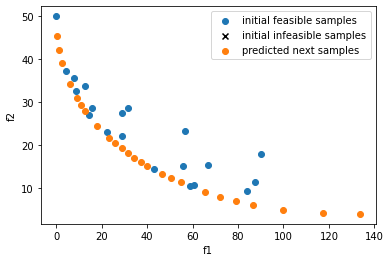

In [0]:
plt.scatter(y[g >= 7.7, 0], y[g >= 7.7, 1], c='#1f77b4',label='initial feasible samples')
plt.scatter(y[g < 7.7, 0], y[g < 7.7, 1],marker='x',c='k',label='initial infeasible samples')
plt.scatter(yupdate[:, 0], yupdate[:, 1], c='#ff7f0e',label='predicted next samples')
plt.ylabel('f2')
plt.xlabel('f1')
plt.legend()
plt.show()